In [173]:
#Import dependency
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import requests
import psycopg2
import config as creds


In [174]:
def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
                 +" password="+ creds.PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    #print("Connected!")

    #Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor


In [175]:
# Connecting to DB

conn, cursor = connect()

# SQL command to create inventory table
sql = "select * from ames;"
#cursor.execute(sql)
df = pd.read_sql_query(sql, conn)
#conn.commit()
# dat = pd.read_sql_query(sql, conn)


**Final Data Cleaning before importing the dataset into our model**

In [176]:
#Drop the ames_order, pid column since it doesn't help with prediction
df.drop(columns=["ames_order"], axis=1, inplace=True)
df

,pid,mssubclass,mszoning,lotarea,street,lotshape,landcontour,lotconfig,landslope,neighborhood,...,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,total_area
0,526301100,20,RL,31770,Pave,IR1,Lvl,Corner,Gtl,NAmes,...,0,0,0,0,5,2010,WD,Normal,215000,4920
1,526350040,20,RH,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,...,0,120,0,0,6,2010,WD,Normal,105000,3404
2,526351010,20,RL,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,...,0,0,0,12500,6,2010,WD,Normal,172000,4299
3,526353030,20,RL,11160,Pave,Reg,Lvl,Corner,Gtl,NAmes,...,0,0,0,0,4,2010,WD,Normal,244000,6852
4,527105010,60,RL,13830,Pave,IR1,Lvl,Inside,Gtl,Gilbert,...,0,0,0,0,3,2010,WD,Normal,189900,4668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2757,923275080,80,RL,7937,Pave,IR1,Lvl,CulDSac,Gtl,Mitchel,...,0,0,0,0,3,2006,WD,Normal,142500,3597
2758,923276100,20,RL,8885,Pave,IR1,Low,Inside,Mod,Mitchel,...,0,0,0,0,6,2006,WD,Normal,131000,3152
2759,923400125,85,RL,10441,Pave,Reg,Lvl,Inside,Gtl,Mitchel,...,0,0,0,700,7,2006,WD,Normal,132000,2852
2760,924100070,20,RL,10010,Pave,Reg,Lvl,Inside,Mod,Mitchel,...,0,0,0,0,4,2006,WD,Normal,170000,4585


In [177]:
categorical = df.select_dtypes('object')
categorical.columns

Index(['pid', 'mssubclass', 'mszoning', 'street', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'overallqual', 'overallcond', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'paveddrive', 'saletype',
       'salecondition'],
      dtype='object')

In [178]:
numerical = df.select_dtypes(exclude='object')
numerical.columns

Index(['lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
       'miscval', 'mosold', 'yrsold', 'saleprice', 'total_area'],
      dtype='object')

**check histogram and see if they are normally distributed in order to be used in linear regression model --> transform the skewed numeric features by taking log(feature + 1) -->make features more normally distributed**

In [179]:
# #Check skewness of the dataset
# from scipy.stats import skew 
# skewness = numerical.apply(lambda x: skew(x))
# skewness.sort_values(ascending=False)

In [180]:
# #normalize the data by taking log
# skewness = np.log(skewness)
# skewness.sort_values(ascending=False)

In [181]:
# # check if saleprice is normally distributed in order to be used in our Multiple linear regression model later
# sns.distplot(df['saleprice']);
# #we can see the saleprice is right skewed

# # transform the the saleprice by taking log to make the data more normally distribute
# df['saleprice'] = np.log1p(df['saleprice'])

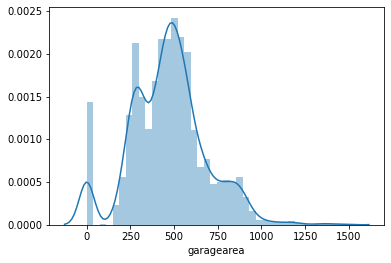

In [182]:
#check the distribution of garagearea
sns.distplot(df['garagearea']);

In [183]:
#dropping any NA before putting the dataset into our model
df = df.dropna()
df.isnull().sum()

pid              0
mssubclass       0
mszoning         0
lotarea          0
street           0
                ..
yrsold           0
saletype         0
salecondition    0
saleprice        0
total_area       0
Length: 66, dtype: int64

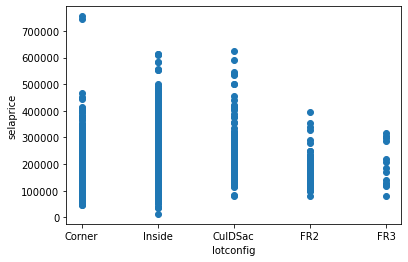

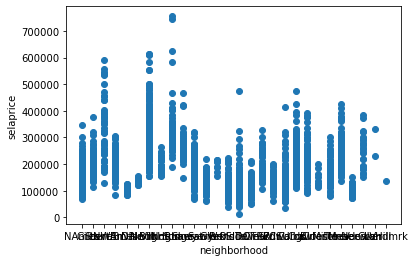

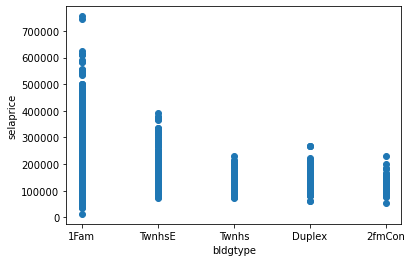

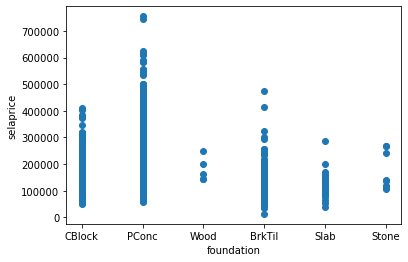

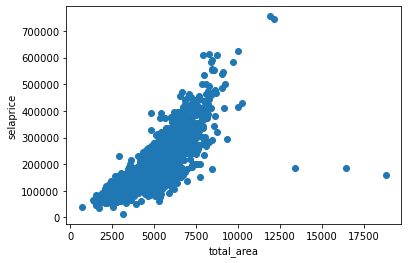

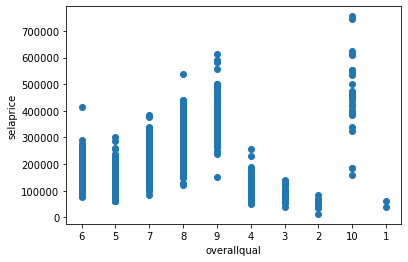

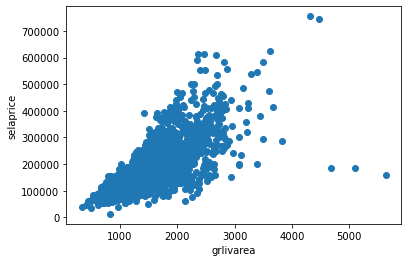

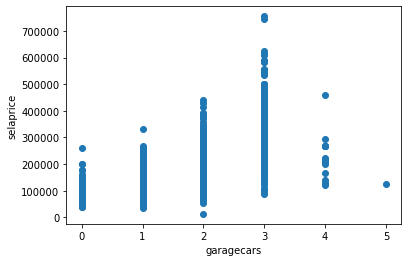

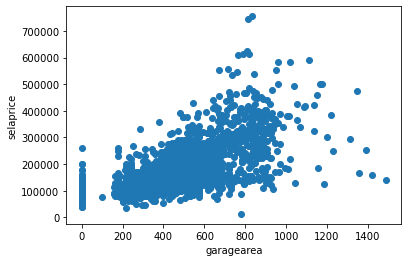

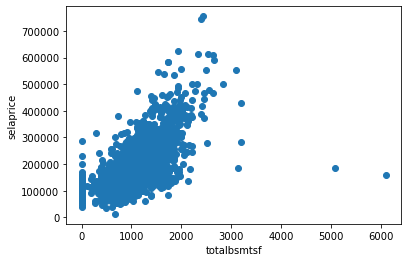

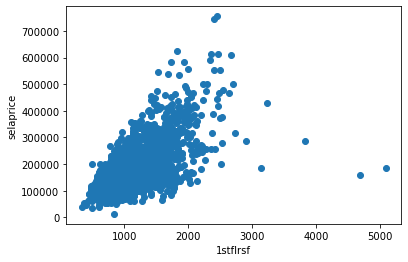

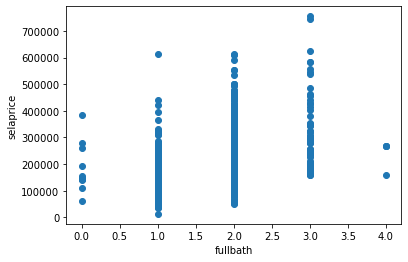

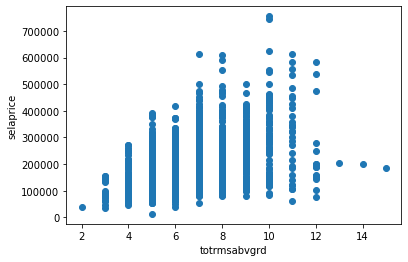

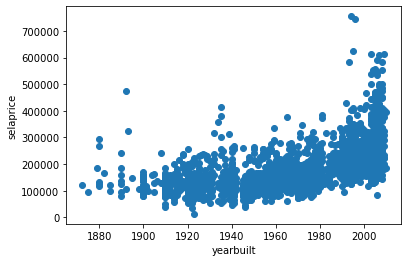

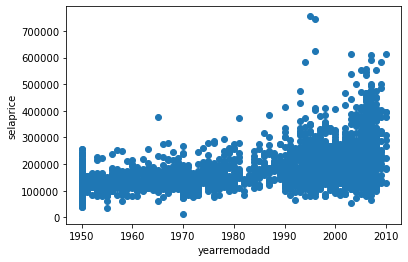

In [184]:
#See the relationship between selected features and target
x_features = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]
for x in x_features:

  plt.scatter(df[x], df['saleprice'])
  plt.xlabel(x)
  plt.ylabel('selaprice')
  plt.show()

# **Initial Features Selection**
we selected 15 features.

***NUmerical Category:***
Based on heatmap, pick the top 11 features that are most correlated to sales price(vmax>0.5). We also added another additional features: total_area

* overallqual
* grlivarea	
* garagecars
* garagearea
* totalbsmtsf	
* 1stflrsf
* fullbath	
* totrmsabvgrd
* yearbuilt	
* yearremodadd
* ADDED total_area

***Categorical Category:***
Categorical object can not be compared using heatmap so we selected a few more features based on commonsense
* lotconfig
* neighborhood
* bldgtype
* foundation


In [185]:
#Determine features and target
feature = df.drop(columns=['saleprice'])
target = df['saleprice']

print(feature)
print(target)

            pid mssubclass mszoning  lotarea street lotshape landcontour  \
0     526301100         20       RL    31770   Pave      IR1         Lvl   
1     526350040         20       RH    11622   Pave      Reg         Lvl   
2     526351010         20       RL    14267   Pave      IR1         Lvl   
3     526353030         20       RL    11160   Pave      Reg         Lvl   
4     527105010         60       RL    13830   Pave      IR1         Lvl   
...         ...        ...      ...      ...    ...      ...         ...   
2757  923275080         80       RL     7937   Pave      IR1         Lvl   
2758  923276100         20       RL     8885   Pave      IR1         Low   
2759  923400125         85       RL    10441   Pave      Reg         Lvl   
2760  924100070         20       RL    10010   Pave      Reg         Lvl   
2761  924151050         60       RL     9627   Pave      Reg         Lvl   

     lotconfig landslope neighborhood  ... enclosedporch 3ssnporch  \
0       Corner   

**Use Label Encoder to to transform categorical features**

In [186]:
#Convert numerical categories that shouldn't be numerical to categorical categories
#please refer to the description file for definition of each category
df['mssubclass'] = df['mssubclass'].astype(str)
df['yrsold'] = df['yrsold'].astype(str)
df['mosold'] = df['mosold'].astype(str)
df['overallcond'] = df['overallcond'].astype(str)
df['overallqual'] = df['overallqual'].astype(str)
df.dtypes

pid              object
mssubclass       object
mszoning         object
lotarea           int64
street           object
                  ...  
yrsold           object
saletype         object
salecondition    object
saleprice         int64
total_area        int64
Length: 66, dtype: object

In [187]:
#transform text into numerical data by applying LabelEncoder 
from sklearn.preprocessing import LabelEncoder
cols = ('mssubclass', 'mszoning', 'street', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'overallqual', 'overallcond', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'paveddrive', 'mosold',
       'yrsold', 'saletype', 'salecondition')

# le = LabelEncoder()
# df2 = df[['neighborhood']].copy(())
# df2['neighborhood_encoded'] = le.fit_transform(list(df['neighborhood'].values))

# print(df2.neighborhood_encoded.unique())
# print(df2.neighborhood.unique())



values = []

for col in cols:
    
    names = df[col].unique
    print(f"names = {names}")
  
    le = LabelEncoder()
    le.fit(list(df[col].values))
    numbers = le.fit_transform(list(df[col].values))
    df[col] = numbers
    
    values.append({"names": names, "numbers": numbers})
    


names = <bound method Series.unique of 0       20
1       20
2       20
3       20
4       60
        ..
2757    80
2758    20
2759    85
2760    20
2761    60
Name: mssubclass, Length: 2762, dtype: object>
names = <bound method Series.unique of 0       RL
1       RH
2       RL
3       RL
4       RL
        ..
2757    RL
2758    RL
2759    RL
2760    RL
2761    RL
Name: mszoning, Length: 2762, dtype: object>
names = <bound method Series.unique of 0       Pave
1       Pave
2       Pave
3       Pave
4       Pave
        ... 
2757    Pave
2758    Pave
2759    Pave
2760    Pave
2761    Pave
Name: street, Length: 2762, dtype: object>
names = <bound method Series.unique of 0       IR1
1       Reg
2       IR1
3       Reg
4       IR1
       ... 
2757    IR1
2758    IR1
2759    Reg
2760    Reg
2761    Reg
Name: lotshape, Length: 2762, dtype: object>
names = <bound method Series.unique of 0       Lvl
1       Lvl
2       Lvl
3       Lvl
4       Lvl
       ... 
2757    Lvl
2758    Low
2759    Lvl


# **Step 4: Multiple Linear Regression Model: Predict house prices based on the selected features**
* Set x and y
* Scale x and y
* Split the data into train and test (X:features, y=target)
* Create an instance of the model with model = LinearRegression().
* Train the model with the dataset with model.fit(X,y)
* Create predictions with y_pred = model.predict(X)


In [188]:
#put our selected features into a list

cols_8 = ["neighborhood","total_area","overallqual", "garagecars","fullbath","yearbuilt","yearremodadd","yrsold"]

#assign y to our target and x to our features 

    y = df['saleprice'].values
    X = df[cols_9]



#try using all the columns as features
# X = df.loc[:, df.columns != 'saleprice']



IndentationError: unexpected indent (<ipython-input-188-c4df657b0268>, line 7)

cols_64 = ['mssubclass', 'mszoning', 'street', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'overallqual', 'overallcond', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'paveddrive', 'mosold',
       'yrsold', 'saletype', 'salecondition']

cols_15 = ["total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]

cols_11 = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","totrmsabvgrd", "yearbuilt","yearremodadd"]

cols_8 = ["neighborhood","total_area","overallqual", "garagecars","fullbath","yearbuilt","yearremodadd","yrsold"]

n = [cols_64, cols_15, cols_11, cols_8]
#assign y to our target and x to our features 

for i in n:
    y = df['saleprice'].values
    X = df[i]
    #data is split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)
    #check the shape of each set
    X_train.shape, X_test.shape, y_train.shape, y_test.shape
    # Define a scaler for the X values and the y values and fit them to the training set
    X_scaler = preprocessing.StandardScaler().fit(X_train)


    # Scale the training set and the testing set using the new scalers
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)



    y_train_scaled = np.log(y_train)
    y_test_scaled = np.log(y_test)

    # Reshape the y values and then print them out
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    print(y_train.shape)
    print(y_test.shape)

    #define the model
    model = linear_model.LinearRegression()
    #build training model --> time start time 
    start=datetime.now()

    # Fit the model to the scaled training set
    model.fit(X_train_scaled, y_train_scaled)

    #time the end time
    end=datetime.now()

    #run prediction on scaled test set 
    y_test_pred = model.predict(X_test_scaled)

    #print the coefficient, intercept, MSE and model score(R^2),and model run time
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    print(f"Mean squared Error(MSE): {mean_squared_error(y_test_scaled, y_test_pred):.2f}")
    print(f"Coefficient of Determination(R^2): {r2_score(y_test_scaled, y_test_pred):.2f}")
    time_taken = end - start
    print(f"Time to run the model: {time_taken}")
 
 PIB?   

In [189]:
X

,neighborhood,total_area,overallqual,garagecars,fullbath,yearbuilt,yearremodadd,yrsold
0,15,4920,6,2,1,1960,1960,4
1,15,3404,5,1,1,1961,1961,4
2,15,4299,6,1,1,1958,1958,4
3,15,6852,7,2,2,1968,1968,4
4,8,4668,5,2,2,1997,1998,4
...,...,...,...,...,...,...,...,...
2757,14,3597,6,2,1,1984,1984,0
2758,14,3152,5,2,1,1983,1983,0
2759,14,2852,5,0,1,1992,1992,0
2760,14,4585,5,2,1,1974,1975,0


Perform 80/20 data split

In [190]:
#data is split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)
#check the shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2209, 8), (553, 8), (2209,), (553,))

In [192]:
# Reshape the y values and then print them out
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(y_train.shape)
print(y_test.shape)

(2209, 1)
(553, 1)


In [194]:
# Define a scaler for the X values and the y values and fit them to the training set
X_scaler = preprocessing.StandardScaler().fit(X_train)


# Scale the training set and the testing set using the new scalers
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)



y_train_scaled = np.log(y_train)
y_test_scaled = np.log(y_test)

In [195]:
# X_scaler.scale_
# X_scaler.inverse_transform

**Fit data to our Multiple Linear Regression Model**

In [196]:
#define the model
model = linear_model.LinearRegression()
#build training model --> time start time 
start=datetime.now()

# Fit the model to the scaled training set
model.fit(X_train_scaled, y_train_scaled)

#time the end time
end=datetime.now()

#run prediction on scaled test set 
y_test_pred = model.predict(X_test_scaled)

# y_test_pred = np.exp(y_test_pred)
# X_scaler.inverse_transform

In [197]:
# Export our model 

from joblib import dump, load
dump(model, 'mlr_model.joblib') 


['mlr_model.joblib']

In [198]:
#print the coefficient, intercept, MSE and model score(R^2),and model run time
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"Mean squared Error(MSE): {mean_squared_error(y_test_scaled, y_test_pred):.2f}")
print(f"Coefficient of Determination(R^2): {r2_score(y_test_scaled, y_test_pred):.2f}")
time_taken = end - start
print(f"Time to run the model: {time_taken}")


Coefficients: [[ 0.00428309  0.21215925  0.09526144  0.03506679 -0.01836104  0.06779652
   0.05328184 -0.0076852 ]]
Intercept: [12.01627885]
Mean squared Error(MSE): 0.03
Coefficient of Determination(R^2): 0.86
Time to run the model: 0:00:00.002329


In [199]:
y_test = pd.DataFrame(y_test)
y_test_pred = np.exp(y_test_pred)
y_test_pred = pd.DataFrame(y_test_pred)
y_test, y_test_pred
df_final = 

(          0
 0    177000
 1    230500
 2    215700
 3    203000
 4    234250
 ..      ...
 548  148000
 549  136870
 550  178000
 551  158000
 552  268500
 
 [553 rows x 1 columns],
                  0
 0    135090.828291
 1    251788.187970
 2    194295.773528
 3    256493.476306
 4    220390.333194
 ..             ...
 548  129498.842023
 549  123914.502238
 550  170759.828023
 551  184191.657734
 552  283448.050776
 
 [553 rows x 1 columns])

In [114]:
# These coefficients need to be updated if you want to use this equation

#Formula for our multiple linear regression model

#y = -2.67021895e-16 + 0.03896429*neighborhood + 0.60886396*total_area + 0.13411633*overallqual + 0.08067865*garagecars + (-0.07035814*fullbath) + 0.16385461*yearbuilt +0.12970701*yearremodadd +(-0.01437204*yrsold) 

In [166]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler

nn_model = tf.keras.models.Sequential()

nn_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu", input_dim = len(X.columns)))
nn_model.add(tf.keras.layers.Dense(units=1, activation="linear"))
nn_model.summary()
nn_model.compile(loss="mean_squared_error", optimizer="adam")
#time starting time
start_1=datetime.now()

nn_model.fit(X_train_scaled, y_train_scaled, epochs=100)
#time ending time
end_1=datetime.now()

y_train_pred = nn_model.predict(X_train_scaled)
y_test_pred = nn_model.predict(X_test_scaled)



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2209/2209 [==============================] - 0s 116us/sample - loss: 137.8394
Epoch 2/100
2209/2209 [==============================] - 0s 26us/sample - loss: 116.9720
Epoch 3/100
2209/2209 [==============================] - 0s 25us/sample - loss: 95.5178
Epoch 4/100
2209/2209 [==============================] - 0s 23us/sample - loss: 73.9652
Epoch 5/100
2209/2209 [==============================] - 0s 22us/sample - loss: 54.7062
Epoch 6/100
2209/2209 [==============================] - 0s 22us/sample - l

2209/2209 [==============================] - 0s 22us/sample - loss: 0.0429
Epoch 88/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.0418
Epoch 89/100
2209/2209 [==============================] - 0s 21us/sample - loss: 0.0415
Epoch 90/100
2209/2209 [==============================] - 0s 21us/sample - loss: 0.0399
Epoch 91/100
2209/2209 [==============================] - 0s 21us/sample - loss: 0.0472
Epoch 92/100
2209/2209 [==============================] - 0s 20us/sample - loss: 0.0399
Epoch 93/100
2209/2209 [==============================] - 0s 20us/sample - loss: 0.0375
Epoch 94/100
2209/2209 [==============================] - 0s 24us/sample - loss: 0.0370
Epoch 95/100
2209/2209 [==============================] - 0s 22us/sample - loss: 0.0369
Epoch 96/100
2209/2209 [==============================] - 0s 21us/sample - loss: 0.0352
Epoch 97/100
2209/2209 [==============================] - 0s 22us/sample - loss: 0.0348
Epoch 98/100
2209/2209 [=====================

In [167]:
# Evaluate the performance of the neural network
print(r2_score(y_train_scaled, y_train_pred))
print(r2_score(y_test_scaled, y_test_pred))


0.7903208439357853
0.7852133107115028


In [169]:
deep_model = tf.keras.models.Sequential()
deep_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu", input_dim = len(X.columns)))
deep_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu"))
deep_model.add(tf.keras.layers.Dense(units=1, activation="linear"))
deep_model.summary()

deep_model.compile(loss="mean_squared_error", optimizer="adam")
#start deep learning starting time
start_2=datetime.now()
deep_model.fit(X_train_scaled, y_train_scaled, epochs=100)
#time deep learning ending time
end_2=datetime.now()
y_train_pred = deep_model.predict(X_train_scaled)
y_test_pred = deep_model.predict(X_test_scaled)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 17        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2209/2209 [==============================] - 0s 152us/sample - loss: 145.6413
Epoch 2/100
2209/2209 [==============================] - 0s 29us/sample - loss: 115.7386
Epoch 3/100
2209/2209 [==============================] - 0s 29us/sample - loss: 67.5565
Epoch 4/100
2209/2209 [==============================] - 0s 26us/sample - loss: 25.8817
Epoch 5/100
2209/2209 [========

2209/2209 [==============================] - 0s 23us/sample - loss: 0.0303
Epoch 86/100
2209/2209 [==============================] - 0s 25us/sample - loss: 0.0282
Epoch 87/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.0280
Epoch 88/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.0296
Epoch 89/100
2209/2209 [==============================] - 0s 22us/sample - loss: 0.0273
Epoch 90/100
2209/2209 [==============================] - 0s 21us/sample - loss: 0.0283
Epoch 91/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.0275
Epoch 92/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.0261
Epoch 93/100
2209/2209 [==============================] - 0s 21us/sample - loss: 0.0300
Epoch 94/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.0306
Epoch 95/100
2209/2209 [==============================] - 0s 23us/sample - loss: 0.0258
Epoch 96/100
2209/2209 [=====================

In [170]:
# Evaluate the performance of the deep learning model
print(r2_score(y_train_scaled, y_train_pred))
print(r2_score(y_test_scaled, y_test_pred))
time_taken_neu = end_1 - start_1
print(time_taken_neu)

time_taken_dl = end_2 - start_2
print(time_taken_dl)

0.8376276223445996
0.8232619016923584
0:00:06.216597
0:00:06.480237


In [172]:
# y_test = pd.DataFrame(y_test)
# y_test_pred = np.exp(y_test_pred)
# y_test_pred = pd.DataFrame(y_test_pred)
y_test_pred = np.exp(y_test_pred)
y_test_pred


array([[126121.96 ],
       [252676.45 ],
       [184971.73 ],
       [236048.33 ],
       [207587.47 ],
       [153813.16 ],
       [ 88446.31 ],
       [184553.78 ],
       [161880.34 ],
       [137757.22 ],
       [139845.47 ],
       [405623.75 ],
       [233968.05 ],
       [134580.7  ],
       [157265.48 ],
       [125445.41 ],
       [101255.28 ],
       [234029.42 ],
       [129266.86 ],
       [147677.8  ],
       [436278.6  ],
       [229135.69 ],
       [201505.8  ],
       [157325.19 ],
       [250791.42 ],
       [184516.12 ],
       [189470.56 ],
       [169536.08 ],
       [ 94551.29 ],
       [102612.05 ],
       [100199.01 ],
       [225147.61 ],
       [107913.74 ],
       [125130.21 ],
       [116947.94 ],
       [170248.17 ],
       [183046.5  ],
       [244110.77 ],
       [167673.31 ],
       [183097.66 ],
       [441851.75 ],
       [195997.61 ],
       [114833.164],
       [182637.25 ],
       [149880.56 ],
       [246932.92 ],
       [139439.03 ],
       [13372

C:\Users\chiko\anaconda3\envs\PythonData\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


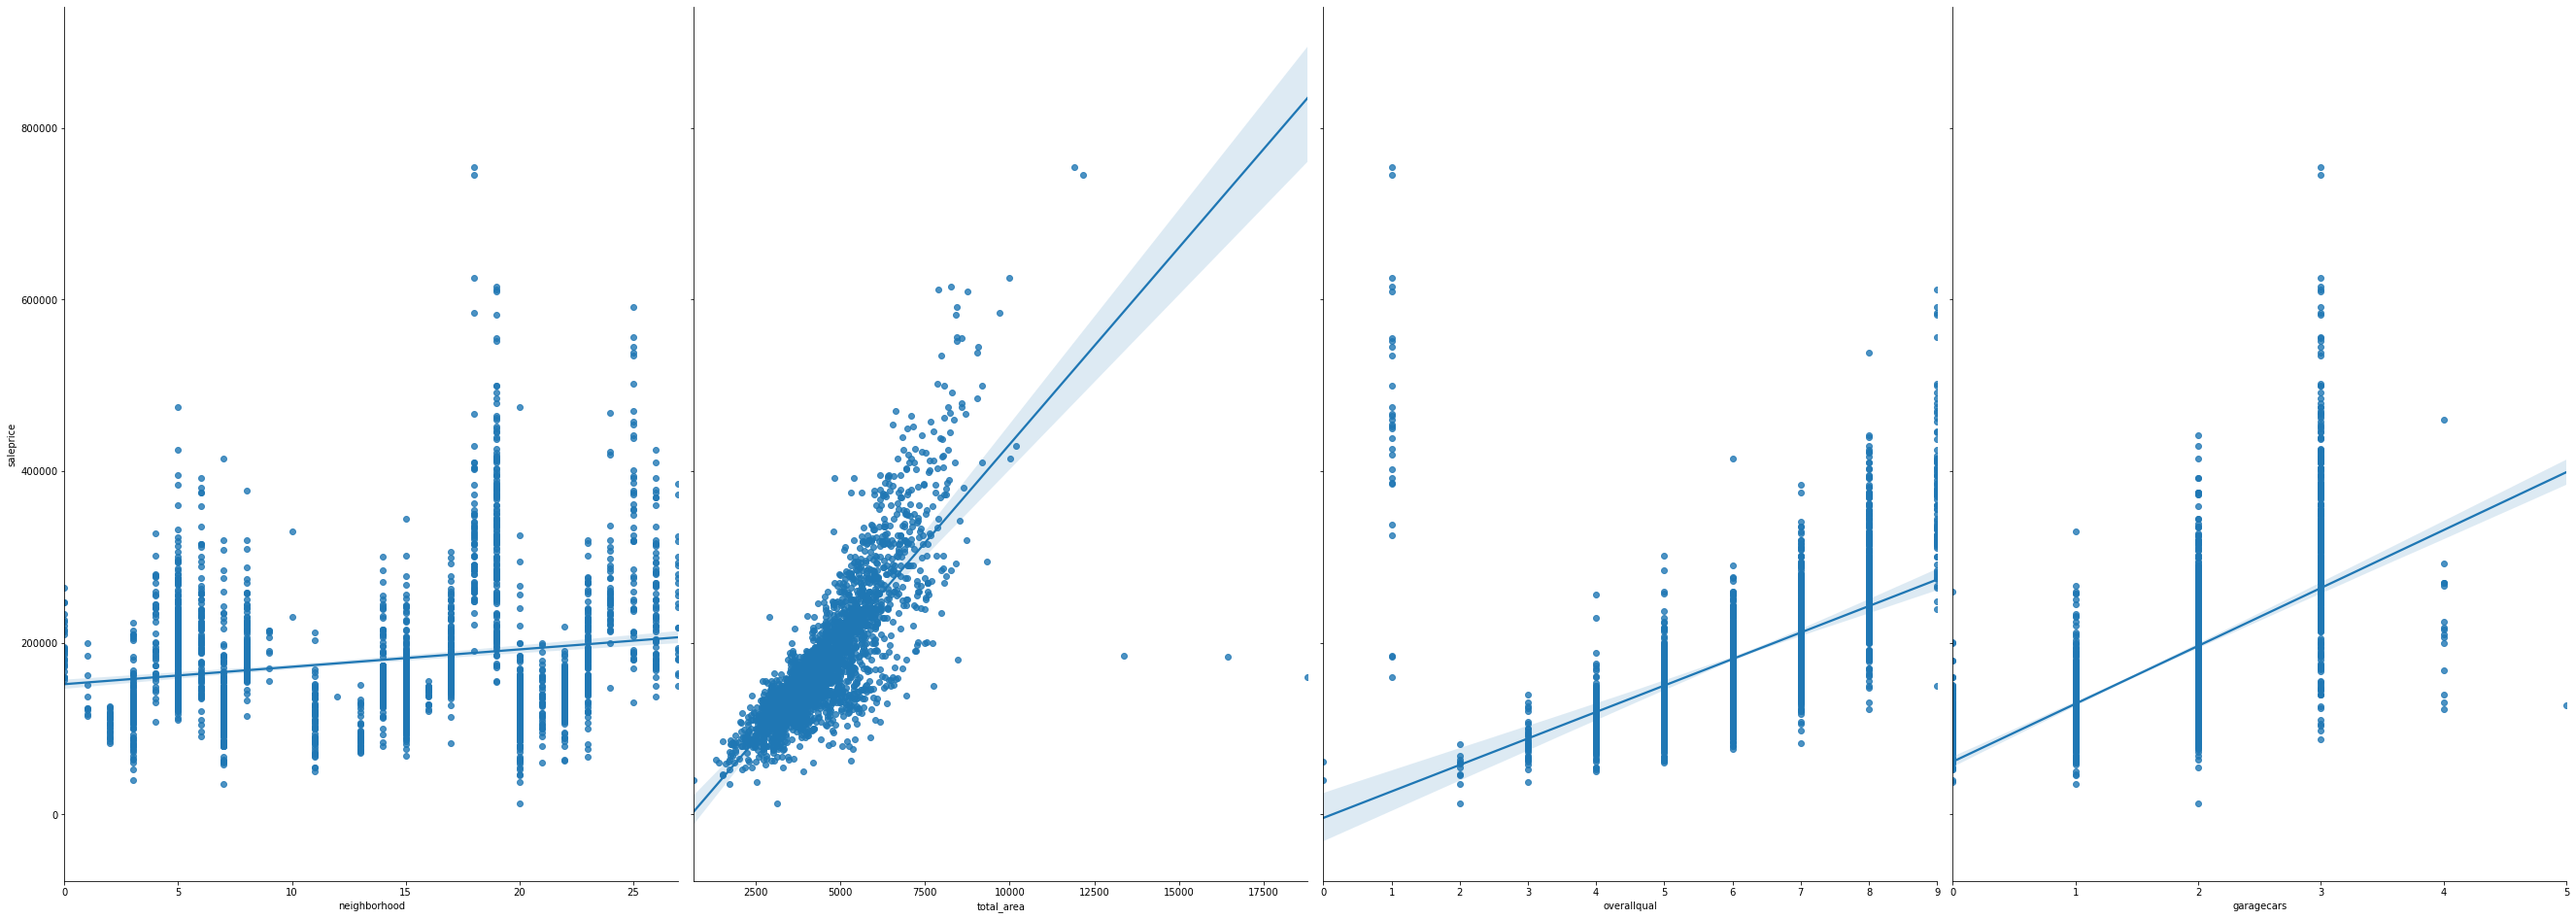

In [30]:
sns.pairplot(df, x_vars=["neighborhood","total_area","overallqual", "garagecars"], y_vars='saleprice', size=13, aspect=0.7, kind='reg')

C:\Users\chiko\anaconda3\envs\PythonData\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


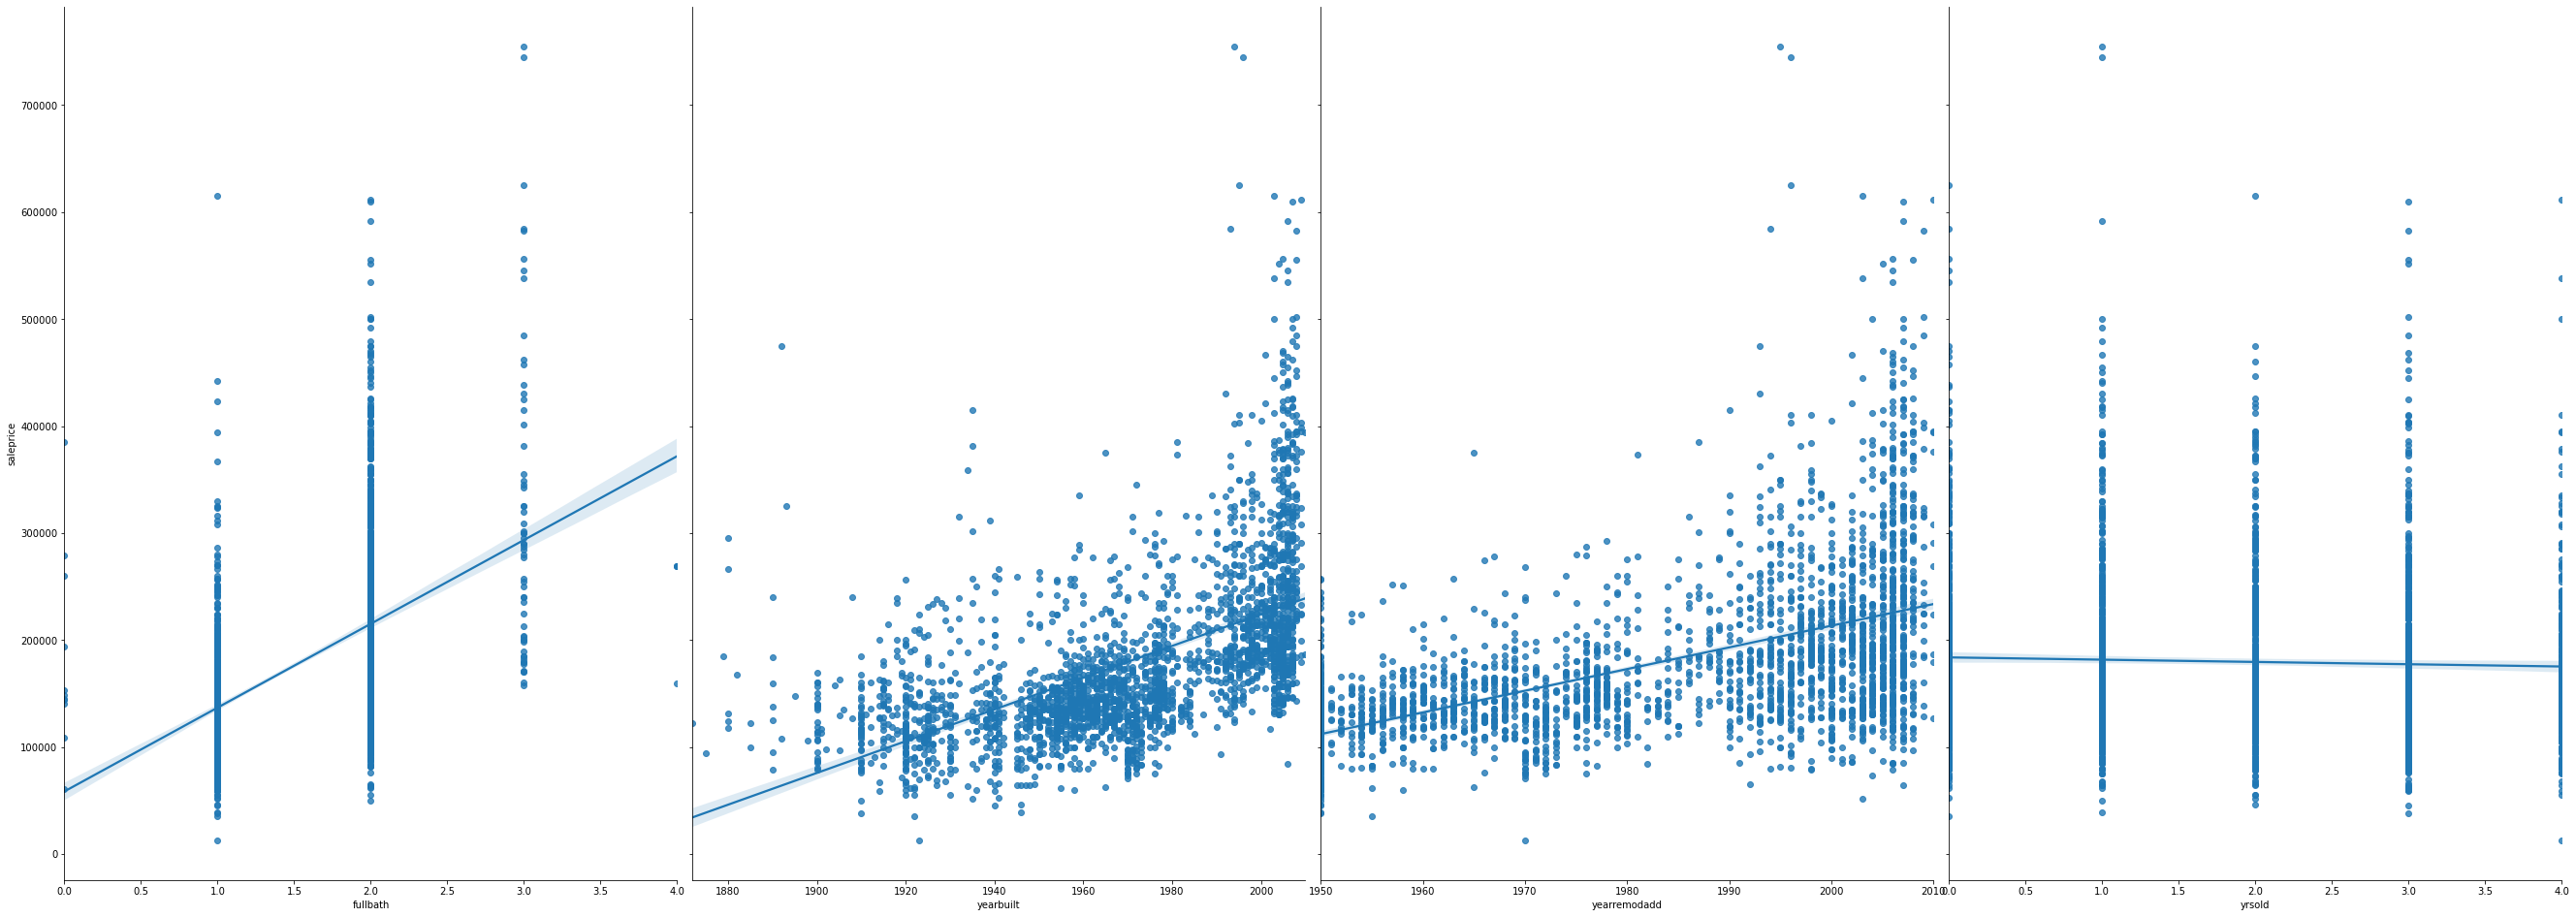

In [35]:
sns.pairplot(df, x_vars=["fullbath","yearbuilt","yearremodadd","yrsold"], y_vars='saleprice', size=13, aspect=0.7, kind='reg')


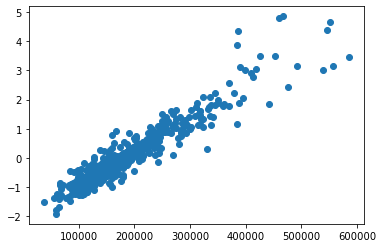

In [31]:
#graph the relationship between y_test and t_test_pred
plt.scatter(y_test, y_test_pred)
plt.show()


In [ ]:
preds = gs.predict(X_test_sc)

#Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(10,8))
plt.scatter(np.exp(preds),y_test,marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')

#Plots x=y line
plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = 'k');

# Models Comparison


**Comparing Multiple Linear Regression VS Deep Learning in terms of model running time**

In [32]:
#import the recording of the model run time and model result
data = pd.read_csv('Resources/run_time_r2.csv')
data = data.dropna()
data

,Features,MLR_R^2,MLR^Run_Time,DL_R^2,DL_Run_Time
0,64,0.90,0.006,0.91,12.12
1,54,0.90,0.003,0.89,12.38
2,44,0.89,0.003,0.87,12.18
3,34,0.88,0.003,0.81,12.53
4,24,0.86,0.003,0.85,12.31
5,15,0.85,0.002,0.82,12.44
6,11,0.85,0.002,0.88,12.71
7,9,0.85,0.002,0.89,12.80
8,8,0.86,0.002,0.89,12.38


<BarContainer object of 2 artists>

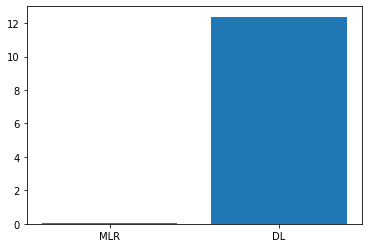

In [33]:
Features = ["8", "15"]
x = ['MLR', 'DL']
y = [0.02, 12.38]
plt.bar(x,y)

**Comparing Multiple Linear Regression VS Deep Learning in terms of R^2**

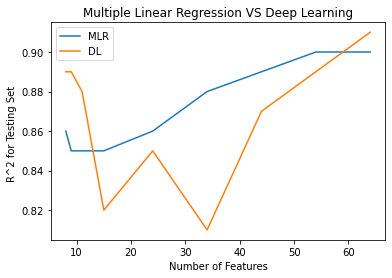

In [39]:
x = data.Features
MLR = data['MLR_R^2']
DL = data['DL_R^2']
fig, ax = plt.subplots()
ax.plot(x,MLR, label='MLR')
ax.plot(x,DL, label='DL')
ax.set_title("Multiple Linear Regression VS Deep Learning")
ax.set_xlabel("Number of Features")
ax.set_ylabel("R^2 for Testing Set ")
ax.legend()